<a href="https://colab.research.google.com/github/RahafAlshahrany/Capstone_Project/blob/main/IT_Project_Portfolio_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IT Project Portfolio Analysis (PMO Style)
This notebook analyzes the uploaded **Project Management Dataset.csv** and produces KPIs, charts, and proxy SPI/CPI.

**Note about SPI/CPI:** The dataset includes a single cost field (Project Cost) and a completion %.
- We compute **CPI (proxy)** as *EV%* (because Actual Cost is not provided separately).
- We compute **SPI (proxy)** using time-based planned progress from Start/End dates and the snapshot month (Year/Month).
This is a common approach when full EVM fields (PV/EV/AC time series) are not available.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd

path = "Project Management Dataset.csv"  # upload this file to Colab
df_raw = pd.read_csv(path)

df = df_raw.copy()
df.columns = df.columns.str.strip()

def to_number(s):
    if pd.isna(s):
        return np.nan
    s = str(s).strip()
    s = s.replace(',', '').replace('$', '').replace('SAR', '').replace('ر.س', '').replace('SR', '')
    s = ''.join(ch for ch in s if ch.isdigit() or ch in ['.', '-'])
    return float(s) if s not in ['', '.', '-', '-.'] else np.nan

def to_percent(s):
    if pd.isna(s):
        return np.nan
    s = str(s).strip().replace('%','')
    s = ''.join(ch for ch in s if ch.isdigit() or ch in ['.', '-'])
    return float(s) if s not in ['', '.', '-', '-.'] else np.nan

df["project_cost"] = df["Project Cost"].map(to_number)
df["project_benefit"] = df["Project Benefit"].map(to_number)
df["completion_pct"] = df["Completion%"].map(to_percent)

df["start_date"] = pd.to_datetime(df["Start Date"], errors="coerce")
df["end_date"] = pd.to_datetime(df["End Date"], errors="coerce")

df["report_date"] = pd.to_datetime(
    df["Year"].astype(str) + "-" + df["Month"].astype(str) + "-01",
    errors="coerce"
) + MonthEnd(0)

df["benefit_cost_ratio"] = df["project_benefit"] / df["project_cost"]
df["planned_duration_days"] = (df["end_date"] - df["start_date"]).dt.days
df["elapsed_days_at_report"] = (df["report_date"] - df["start_date"]).dt.days
df["planned_pct_time"] = (df["elapsed_days_at_report"] / df["planned_duration_days"]).clip(lower=0, upper=1)

df["ev_pct"] = (df["completion_pct"] / 100).clip(lower=0, upper=1)
df["spi_proxy"] = df["ev_pct"] / df["planned_pct_time"]
df.loc[df["planned_pct_time"].isna() | (df["planned_pct_time"] == 0), "spi_proxy"] = np.nan

df["cpi_proxy"] = df["ev_pct"]  # because Actual Cost is not available separately

df["status"] = df["Status"].astype(str).str.strip()
df["complexity"] = df["Complexity"].astype(str).str.strip()
df["phase"] = df["Phase"].astype(str).str.strip()
df["project_type"] = df["Project Type"].astype(str).str.strip()
df["region"] = df["Region"].astype(str).str.strip()
df["department"] = df["Department"].astype(str).str.strip()

df.head()


,Project Name,Project Description,Project Type,Project Manager,Region,Department,Project Cost,Project Benefit,Complexity,Status,...,planned_pct_time,ev_pct,spi_proxy,cpi_proxy,status,complexity,phase,project_type,region,department
0,Rhinestone,Associations Now Is A Casual Game To Teach You...,INCOME GENERATION,Yael Wilcox,North,Admin & BI,"3,648,615.00","8,443,980.00",High,In - Progress,...,0.225000,0.77,3.422222,0.77,In - Progress,High,Phase 4 - Implement,INCOME GENERATION,North,Admin & BI
1,A Triumph Of Softwares,Is A Fully Managed Content Marketing Software ...,INCOME GENERATION,Brenda Chandler,West,eCommerce,"4,018,835.00","9,012,225.00",High,Cancelled,...,0.326087,0.80,2.453333,0.80,Cancelled,High,Phase 2 - Develop,INCOME GENERATION,West,eCommerce
2,The Blue Bird,Most Content Marketers Know The Golden Rule: Y...,INCOME GENERATION,Nyasia Hunter,North,Warehouse,"4,285,483.00","9,078,339.00",High,Completed,...,0.326087,1.00,3.066667,1.00,Completed,High,Phase 4 - Implement,INCOME GENERATION,North,Warehouse
3,Remembering Our Ancestors,"Utilize And Utilizes (Verb Form) The Open, Inc...",PROCESS IMPROVEMENT,Brenda Chandler,East,Sales and Marketing,"5,285,864.00","8,719,006.00",High,Cancelled,...,0.326087,0.75,2.300000,0.75,Cancelled,High,Phase 5 - Measure,PROCESS IMPROVEMENT,East,Sales and Marketing
4,Skyhawks,Is A Solution For Founders Who Want To Win At ...,WORKING CAPITAL IMPROVEMENT,Jaylyn Mckenzie,East,eCommerce,"5,785,601.00","8,630,148.00",High,Completed,...,0.326087,1.00,3.066667,1.00,Completed,High,Phase 1 - Explore,WORKING CAPITAL IMPROVEMENT,East,eCommerce


In [3]:
# KPIs
kpis = {
    "Total Projects": len(df),
    "Avg Project Cost": df["project_cost"].mean(),
    "Median Project Cost": df["project_cost"].median(),
    "Avg Project Benefit": df["project_benefit"].mean(),
    "Median Project Benefit": df["project_benefit"].median(),
    "Avg Completion %": df["completion_pct"].mean(),
    "Avg Benefit/Cost Ratio": df["benefit_cost_ratio"].mean(),
    "Avg SPI (proxy)": df["spi_proxy"].mean(),
    "Median SPI (proxy)": df["spi_proxy"].median(),
    "Avg CPI (proxy)": df["cpi_proxy"].mean(),
}

pd.DataFrame.from_dict(kpis, orient="index", columns=["Value"]).round(3)


,Value
Total Projects,99.000
Avg Project Cost,4156649.364
Median Project Cost,4172827.000
Avg Project Benefit,8828178.131
Median Project Benefit,8846243.000
Avg Completion %,87.010
Avg Benefit/Cost Ratio,2.283
Avg SPI (proxy),2.837
Median SPI (proxy),2.791
Avg CPI (proxy),0.870


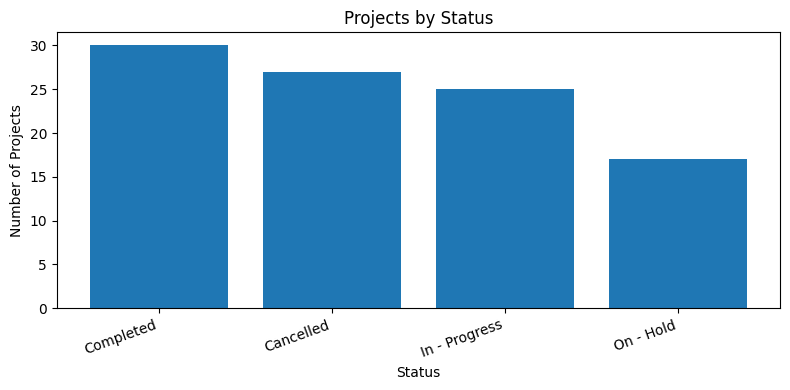

In [4]:
# 1) Status distribution
status_counts = df["status"].value_counts()

plt.figure(figsize=(8,4))
plt.bar(status_counts.index, status_counts.values)
plt.title("Projects by Status")
plt.xlabel("Status")
plt.ylabel("Number of Projects")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()


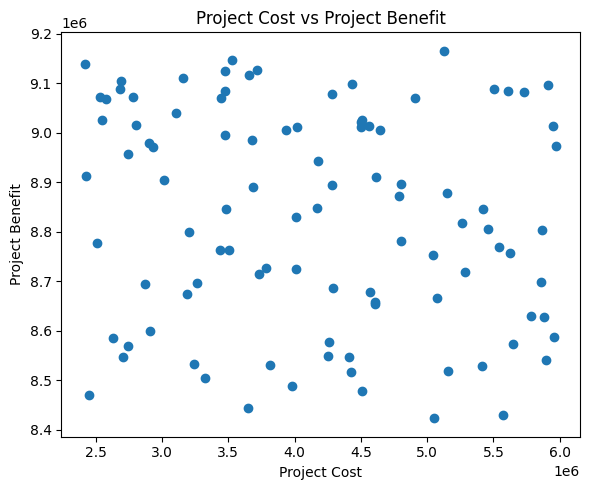

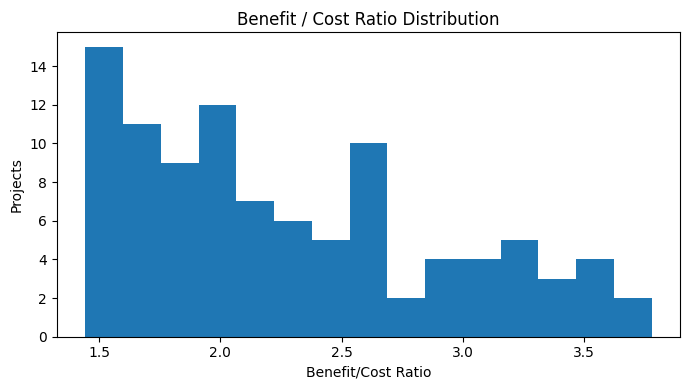

In [5]:
# 2) Cost vs Benefit scatter (value view)
plt.figure(figsize=(6,5))
plt.scatter(df["project_cost"], df["project_benefit"])
plt.title("Project Cost vs Project Benefit")
plt.xlabel("Project Cost")
plt.ylabel("Project Benefit")
plt.tight_layout()
plt.show()

# 3) Benefit/Cost ratio distribution
plt.figure(figsize=(7,4))
plt.hist(df["benefit_cost_ratio"].replace([np.inf, -np.inf], np.nan).dropna(), bins=15)
plt.title("Benefit / Cost Ratio Distribution")
plt.xlabel("Benefit/Cost Ratio")
plt.ylabel("Projects")
plt.tight_layout()
plt.show()


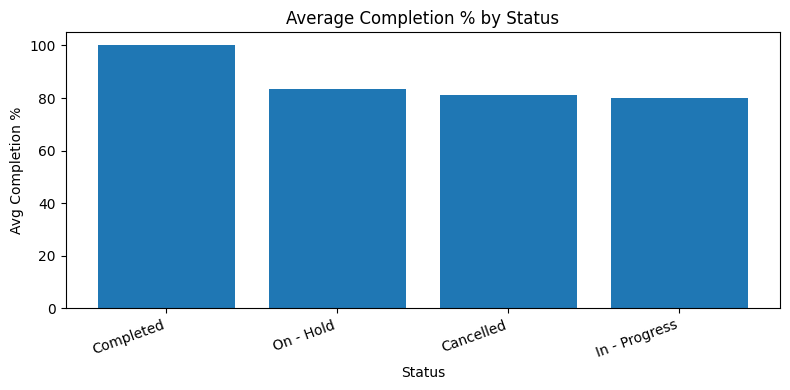

In [6]:
# 4) Completion % by Status
grp = df.groupby("status")["completion_pct"].mean().sort_values(ascending=False)

plt.figure(figsize=(8,4))
plt.bar(grp.index, grp.values)
plt.title("Average Completion % by Status")
plt.xlabel("Status")
plt.ylabel("Avg Completion %")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()


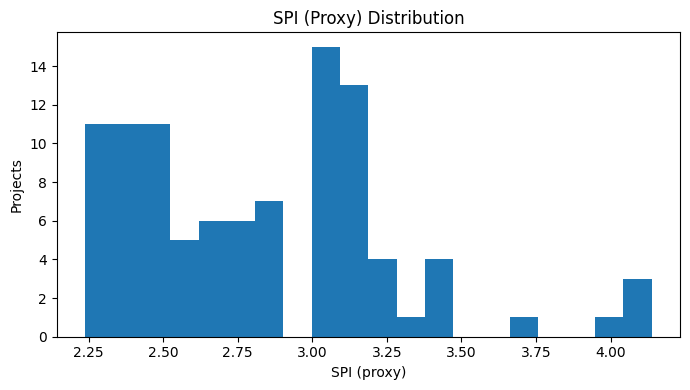

,count
spi_bucket,
Ahead (>1.1),99


In [7]:
# 5) SPI proxy distribution + rule-of-thumb thresholds
spi = df["spi_proxy"].replace([np.inf, -np.inf], np.nan).dropna()

plt.figure(figsize=(7,4))
plt.hist(spi, bins=20)
plt.title("SPI (Proxy) Distribution")
plt.xlabel("SPI (proxy)")
plt.ylabel("Projects")
plt.tight_layout()
plt.show()

# Categorize SPI proxy
def spi_bucket(x):
    if pd.isna(x): return np.nan
    if x < 0.9: return "Behind (<0.9)"
    if x <= 1.1: return "On Track (0.9–1.1)"
    return "Ahead (>1.1)"

df["spi_bucket"] = df["spi_proxy"].apply(spi_bucket)
df["spi_bucket"].value_counts(dropna=True)


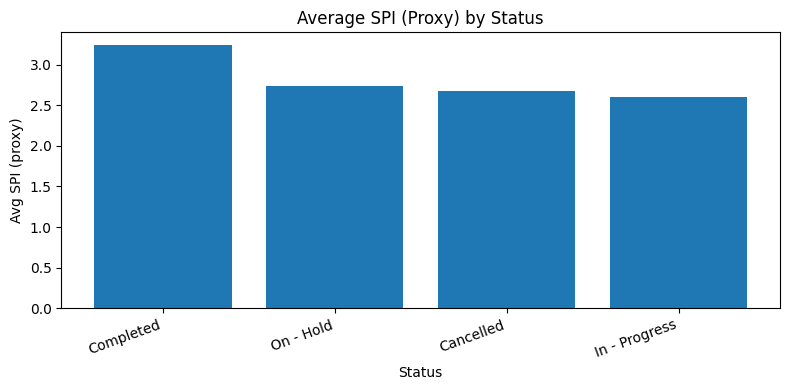

In [8]:
# 6) SPI proxy by Status (mean)
spi_by_status = df.groupby("status")["spi_proxy"].mean().sort_values(ascending=False)

plt.figure(figsize=(8,4))
plt.bar(spi_by_status.index, spi_by_status.values)
plt.title("Average SPI (Proxy) by Status")
plt.xlabel("Status")
plt.ylabel("Avg SPI (proxy)")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()


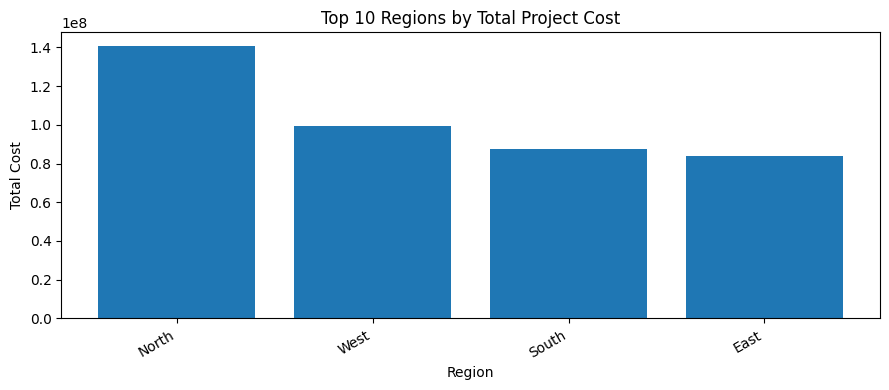

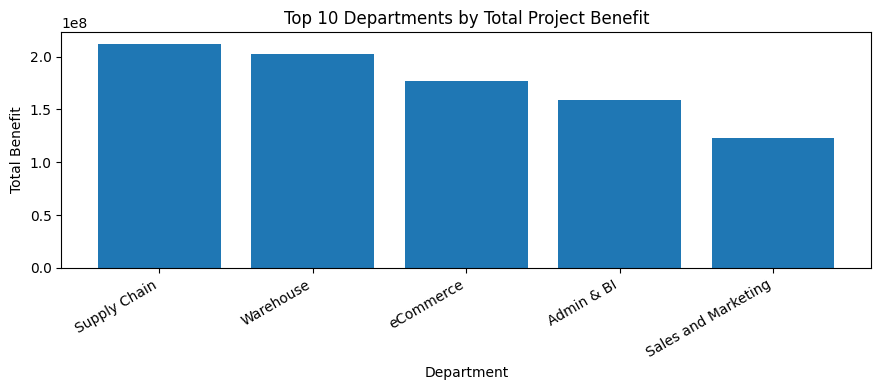

In [9]:
# 7) Portfolio view: total cost and benefit by Region / Department (Top 10)
top_region_cost = df.groupby("region")["project_cost"].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(9,4))
plt.bar(top_region_cost.index, top_region_cost.values)
plt.title("Top 10 Regions by Total Project Cost")
plt.xlabel("Region")
plt.ylabel("Total Cost")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

top_dept_benefit = df.groupby("department")["project_benefit"].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(9,4))
plt.bar(top_dept_benefit.index, top_dept_benefit.values)
plt.title("Top 10 Departments by Total Project Benefit")
plt.xlabel("Department")
plt.ylabel("Total Benefit")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


In [10]:
# 8) Data-quality flags (important for PMO credibility)
# Flag projects where completion is much higher than time-based planned progress
df["progress_gap"] = df["ev_pct"] - df["planned_pct_time"]

flags = {
    "Projects with completion >= 90% while time plan <= 50%": int(((df["ev_pct"]>=0.9) & (df["planned_pct_time"]<=0.5)).sum()),
    "Projects with SPI proxy > 2 (very ahead / possible reporting issue)": int((df["spi_proxy"]>2).sum()),
    "Projects with missing/invalid ratio": int(df["benefit_cost_ratio"].replace([np.inf, -np.inf], np.nan).isna().sum())
}
pd.DataFrame.from_dict(flags, orient="index", columns=["Count"])


,Count
Projects with completion >= 90% while time plan <= 50%,39
Projects with SPI proxy > 2 (very ahead / possible reporting issue),99
Projects with missing/invalid ratio,0


## Executive Insights

### Portfolio Overview
- The project portfolio demonstrates strong value potential, with the average project benefit exceeding the average project cost by more than two times.
- Overall project completion is relatively high, indicating progress across most initiatives.

### Delivery Performance
- Despite strong value indicators, a significant portion of projects are either cancelled or on hold, highlighting challenges in project initiation and prioritization.
- Schedule performance analysis (SPI – proxy) suggests that several projects appear ahead of schedule; however, this is likely influenced by inconsistencies in progress reporting.

### Data Quality & Governance
- The observed gap between reported completion percentages and time-based planned progress indicates a need for standardized progress measurement.
- The absence of detailed earned value data (PV and AC) limits the ability to calculate true SPI and CPI, emphasizing the importance of improving cost and schedule tracking practices.

### Key Recommendations
- Strengthen project initiation and business case evaluation to reduce late-stage cancellations.
- Standardize earned value measurement and reporting definitions across projects.
- Introduce consistent tracking of planned value (PV) and actual cost (AC) to enable accurate CPI and SPI calculations.
- Use SPI and CPI as early warning indicators to proactively manage project risks.

